## 交叉验证

验证模型结果的稳定性，采用5重交叉验证，其中每重的训练数据用于训练，测试数据用于测试最后得到平均测试准确率。

In [11]:
# coding: utf-8

%matplotlib inline

import os
import time
import pickle

import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


def load_pickled_data(pickled_file):
    """
    load picked data
    :param pickled_file:
    :return: train_data, train_labels, test_data,
             test_labels, valid_data, valid_labels
    """
    with open(pickled_file, 'rb') as f:
        save = pickle.load(f)
        _train_data = save['train_data']
        _train_labels = save['train_labels']
        _test_data = save['test_data']
        _test_labels = save['test_labels']
        _valid_data = save['valid_data']
        _valid_labels = save['valid_labels']
        del save
        print(_train_data.shape, _train_labels.shape)
        print(_test_data.shape, _test_labels.shape)
        print(_valid_data.shape, _valid_labels.shape)
    return _train_data, _train_labels, _test_data, _test_labels, _valid_data, _valid_labels


def accuracy_func(predicts, labels):
    """
    total accuracy, digit-wise
    :param predicts:
    :param labels:
    :return: float value, precesion
    """
    _predictions = np.argmax(predicts, 2).T
    total_count = 0
    for pre, la in zip(_predictions, labels):
        for i, j in zip(pre.tolist(), la.tolist()):
            if i == j:
                total_count += 1
    # return 100.0 * np.sum(predictions == labels) / predicts.shape[1] / predicts.shape[0]
    return 100.0 * total_count / predicts.shape[1] / predicts.shape[0]


def local_contrast_normalization(input_data, image_shape, threshold=1e-4, radius=7):
    """
    Local Contrast Normalization
    :param input_data: input data
    :param image_shape: image shape
    :param threshold: threshold
    :param radius: redius
    :return: local contrast normalized input data
    """
    # Gaussian filter
    filter_shape = radius, radius, image_shape[3], 1
    filters = gaussian_initializer(filter_shape)
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
    convout = tf.nn.conv2d(input_data, filters, [1, 1, 1, 1], 'SAME')
    centered_data = tf.sub(input_data, convout)
    denoms = tf.sqrt(tf.nn.conv2d(tf.square(centered_data), filters, [1, 1, 1, 1], 'SAME'))
    mean = tf.reduce_mean(denoms)
    divisor = tf.maximum(mean, denoms)
    # Divisise step
    new_data = tf.truediv(centered_data, tf.maximum(divisor, threshold))
    return new_data


def gaussian_initializer(kernel_shape):
    """
    initialize the kernel weights
    :param kernel_shape: kernel shape
    :return: tensor
    """
    x = np.zeros(kernel_shape, dtype=float)
    mid = np.floor(kernel_shape[0] / 2.)
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):
            for j in range(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gaussian(i - mid, j - mid)
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)


def gaussian(x, y, sigma=3.0):
    """
    gaussian function
    :param x: x value
    :param y: y value
    :param sigma: sigma
    :return: guassian normalized value
    """
    z = 2 * np.pi * sigma ** 2
    return 1. / z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))


In [2]:

class MultiDigits(object):
    """
    Multi Digits Recognition Model
    """
    def __init__(self, picked_file=None, image_size=32, num_labels=11, num_channels=1,
                 batch_size=64, patch_size=5, depth_1=16, depth_2=32, depth_3=64,
                 hidden_num=64, num_hidden1=64
                 ):
        """
        :param picked_file:
        :param image_size:
        :param num_labels:
        :param num_channels:
        :param batch_size:
        :param patch_size:
        :param depth_1:
        :param depth_2:
        :param depth_3:
        :param hidden_num:
        :param num_hidden1:
        """
        self.train_data, self.train_labels, self.test_data, \
            self.test_labels, self.valid_data, self.valid_labels = None, None, None, None, None, None
        if picked_file is not None:
            self.train_data, self.train_labels, self.test_data, \
                self.test_labels, self.valid_data, self.valid_labels = \
                load_pickled_data(picked_file)
        self.train_graph = None
        self.infer_graph = tf.Graph()
        self.image_size = image_size
        self.num_labels = num_labels
        self.num_channels = num_channels
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.depth_1 = depth_1
        self.depth_2 = depth_2
        self.depth_3 = depth_3
        self.hidden_num = hidden_num
        self.num_hidden1 = num_hidden1
        self.shape = [batch_size, image_size, image_size, num_channels]
        self.saver = None
        self.valid_prediction, self.test_prediction = None, None
        self.tf_train_dataset = tf.placeholder(tf.float32, shape=self.shape)
        self.tf_train_labels = None
        self.tf_valid_dataset = None
        self.tf_test_dataset = None
        self.loss = None
        self.optimizer = None
        self.train_prediction = None
        self.save_path = None
        self.infer_saver = None
        self.is_inited = False
        self.conv_layer1_weights = None
        self.conv_layer1_biases = None
        self.conv_layer2_weights = None
        self.conv_layer2_biases = None
        self.conv_layer2_biases = None
        self.conv_layer3_weights = None
        self.conv_layer3_biases = None
        self.out_weights_len = None
        self.out_biases_len = None
        self.out_weights_1 = None
        self.out_biases_1 = None
        self.out_weights_2 = None
        self.out_weights_2 = None
        self.out_biases_2 = None
        self.out_weights_3 = None
        self.out_biases_3 = None
        self.out_weights_4 = None
        self.out_biases_4 = None
        self.out_weights_5 = None
        self.out_biases_5 = None

    def init_data(self, picked_file=None):
        if picked_file is not None:
            self.train_data, self.train_labels, self.test_data, \
                self.test_labels, self.valid_data, self.valid_labels = \
                load_pickled_data(picked_file)

    def define_graph(self, keep_pro=0.95, eta=0.05, decay_step=5000, decay_rate=0.95):
        """
        定义图参数
        :param keep_pro: DropOut参数
        :param eta: 学习率
        :param decay_step: 学习率衰减步
        :param decay_rate: 学习率衰减率
        :return:
        """
        self.train_graph = tf.Graph()
        with self.train_graph.as_default():
            # Input Data.
            self.tf_train_dataset = tf.placeholder(tf.float32, shape=self.shape)
            self.tf_train_labels = tf.placeholder(tf.int32, shape=(self.batch_size, 6))
            self.tf_valid_dataset = tf.constant(self.valid_data)
            self.tf_test_dataset = tf.constant(self.test_data)
            # init varibales
            # Conv Layers
            self.conv_layer1_weights = tf.get_variable('c_1_w', shape=[self.patch_size, self.patch_size,
                                                                       self.num_channels, self.depth_1],
                                                       initializer=tf.contrib.layers.xavier_initializer_conv2d())
            self.conv_layer1_biases = tf.Variable(tf.constant(1.0, shape=[self.depth_1]), name='c_1_b')
            self.conv_layer2_weights = tf.get_variable('c_2_w', shape=[self.patch_size, self.patch_size,
                                                                       self.depth_1, self.depth_2],
                                                       initializer=tf.contrib.layers.xavier_initializer_conv2d())
            self.conv_layer2_biases = tf.Variable(tf.constant(1.0, shape=[self.depth_2]), name='c_2_b')
            self.conv_layer3_weights = tf.get_variable('c_3_w', shape=[self.patch_size, self.patch_size,
                                                                       self.depth_2, self.num_hidden1],
                                                       initializer=tf.contrib.layers.xavier_initializer_conv2d())
            self.conv_layer3_biases = tf.Variable(tf.constant(1.0, shape=[self.num_hidden1]), name='c_3_b')
            # Output Layer
            self.out_weights_len = tf.get_variable('o_len', shape=[self.hidden_num, self.num_labels],
                                                   initializer=tf.contrib.layers.xavier_initializer())
            self.out_biases_len = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_len'))
            self.out_weights_1 = tf.get_variable('o_1', shape=[self.hidden_num, self.num_labels],
                                                 initializer=tf.contrib.layers.xavier_initializer())
            self.out_biases_1 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_1'))
            self.out_weights_2 = tf.get_variable('o_2', shape=[self.hidden_num, self.num_labels],
                                                 initializer=tf.contrib.layers.xavier_initializer())
            self.out_biases_2 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_2'))
            self.out_weights_3 = tf.get_variable('o_3', shape=[self.hidden_num, self.num_labels],
                                                 initializer=tf.contrib.layers.xavier_initializer())
            self.out_biases_3 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_3'))
            self.out_weights_4 = tf.get_variable('o_4', shape=[self.hidden_num, self.num_labels],
                                                 initializer=tf.contrib.layers.xavier_initializer())
            self.out_biases_4 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_4'))
            self.out_weights_5 = tf.get_variable('o_5', shape=[self.hidden_num, self.num_labels],
                                                 initializer=tf.contrib.layers.xavier_initializer())
            self.out_biases_5 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_5'))
            # Training computation.
            logitslen, logits1, logits2, logits3, logits4, logits5 = \
                self._infer(self.tf_train_dataset, keep_pro, self.shape)
            self.loss = \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logitslen, self.tf_train_labels[:, 0])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, self.tf_train_labels[:, 1])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, self.tf_train_labels[:, 2])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, self.tf_train_labels[:, 3])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, self.tf_train_labels[:, 4])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, self.tf_train_labels[:, 5]))
            # Optimizer.
            global_step = tf.Variable(0)
            learning_rate = tf.train.exponential_decay(eta, global_step, decay_step, decay_rate)
            self.optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(self.loss, global_step=global_step)
            # Predictions of the training, validation, and test data.
            self.train_prediction = tf.pack(list(map(tf.nn.softmax,
                                                     self._infer(self.tf_train_dataset, 1.0, self.shape))))
            self.valid_prediction = tf.pack(list(map(tf.nn.softmax,
                                                     self._infer(self.tf_valid_dataset, 1.0, self.shape))))
            self.test_prediction = tf.pack(list(map(tf.nn.softmax,
                                                    self._infer(self.tf_test_dataset, 1.0, self.shape))))
            self.saver = tf.train.Saver()

    def train_model(self, save_path=None, save=True, epoch=50000, verbose=False, cross_validate=False):
        """
        训练模型，部署应用的时候不能调用
        :param save_path: ckpt数据保存路径
        :param save: 是否保存ckpt数据
        :param epoch: 训练迭代次数
        :param verbose: 显示迭代过程中的中间结果
        :param cross_validate: 是否是交叉验证
        :return: epoch_index, losses, mini_batch_acc, valid_batch_acc, test_acc
        """
        epoch_index = []
        losses = []
        mini_batch_acc = []
        valid_batch_acc = []
        epochs = epoch
        start_time = time.time()
        with tf.Session(graph=self.train_graph) as sess:
            tf.global_variables_initializer().run()
            print('Initialized all variables')
            for e in range(epochs):
                offset = (e * self.batch_size) % (self.train_labels.shape[0] - self.batch_size)
                batch_data = self.train_data[offset:(offset + self.batch_size), :, :, :]
                batch_labels = self.train_labels[offset:(offset + self.batch_size), :]
                feed_dict = {self.tf_train_dataset: batch_data, self.tf_train_labels: batch_labels}
                _, l, predictions = sess.run([self.optimizer, self.loss, self.train_prediction], feed_dict=feed_dict)
                if e % 1000 == 0:
                    epoch_index.append(e)
                    mini_acc = accuracy_func(predictions, batch_labels)
                    mini_batch_acc.append(mini_acc)
                    valid_acc = accuracy_func(self.valid_prediction.eval(), self.valid_labels)
                    valid_batch_acc.append(valid_acc)
                    losses.append(l)
                    if verbose:
                        print('Minibatch loss at step %d: %f' % (e, l))
                        print('Minibatch accuracy: %.1f%%' % mini_acc)
                        if not cross_validate:
                            print('Validation accuracy: %.1f%%' % valid_acc)
            test_acc = accuracy_func(self.test_prediction.eval(), self.test_labels)
            print('Test accuracy: %.1f%%' % test_acc)
            if save:
                self.save_path = self.saver.save(sess, save_path)
                print("Model saved in file: %s" % self.save_path)
            end_time = time.time()
            print('train time: %s' % (end_time - start_time))
        return epoch_index, losses, mini_batch_acc, valid_batch_acc, test_acc

    def infer_model(self, input_data, ckpt_path):
        """
        infer input data
        :param input_data: input a instance
        :param ckpt_path: path to the ckpt file
        :return: return result
        """
        infer_graph = tf.Graph()
        with infer_graph.as_default():
            # Input Data.
            tf_infer_data = tf.placeholder(tf.float32, shape=(input_data.shape[0], input_data.shape[1],
                                                              input_data.shape[2], 1))
            # init varibales
            conv_layer1_weights = tf.get_variable('c_1_w', shape=[self.patch_size, self.patch_size,
                                                                  self.num_channels, self.depth_1],
                                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
            conv_layer1_biases = tf.Variable(tf.constant(1.0, shape=[self.depth_1]), name='c_1_b')
            conv_layer2_weights = tf.get_variable('c_2_w', shape=[self.patch_size, self.patch_size,
                                                                  self.depth_1, self.depth_2],
                                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
            conv_layer2_biases = tf.Variable(tf.constant(1.0, shape=[self.depth_2]), name='c_2_b')
            conv_layer3_weights = tf.get_variable('c_3_w', shape=[self.patch_size, self.patch_size,
                                                                  self.depth_2, self.num_hidden1],
                                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
            conv_layer3_biases = tf.Variable(tf.constant(1.0, shape=[self.num_hidden1]), name='c_3_b')
            # Output Layer
            out_weights_len = tf.get_variable('o_len', shape=[self.hidden_num, self.num_labels],
                                              initializer=tf.contrib.layers.xavier_initializer())
            out_biases_len = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_len'))
            out_weights_1 = tf.get_variable('o_1', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_1 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_1'))
            out_weights_2 = tf.get_variable('o_2', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_2 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_2'))
            out_weights_3 = tf.get_variable('o_3', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_3 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_3'))
            out_weights_4 = tf.get_variable('o_4', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_4 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_4'))
            out_weights_5 = tf.get_variable('o_5', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_5 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_5'))

            def infer(data, keep_prob, d_shape):
                # conv layer
                lcn = local_contrast_normalization(data, d_shape)
                conv_1 = tf.nn.conv2d(lcn, conv_layer1_weights, [1, 1, 1, 1], 'VALID', name='c_1')
                conv_1 = tf.nn.relu(conv_1 + conv_layer1_biases)
                conv_1 = tf.nn.local_response_normalization(conv_1)
                pool_1 = tf.nn.max_pool(conv_1, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='p_1')
                conv_2 = tf.nn.conv2d(pool_1, conv_layer2_weights, [1, 1, 1, 1], padding='VALID', name='c_2')
                conv_2 = tf.nn.relu(conv_2 + conv_layer2_biases)
                conv_2 = tf.nn.local_response_normalization(conv_2)
                pool_2 = tf.nn.max_pool(conv_2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='p_2_')
                conv_3 = tf.nn.conv2d(pool_2, conv_layer3_weights, [1, 1, 1, 1], padding='VALID', name='c_3')
                conv_3 = tf.nn.relu(conv_3 + conv_layer3_biases)
                conv_3 = tf.nn.dropout(conv_3, keep_prob)
                shapes = conv_3.get_shape().as_list()
                hidden = tf.reshape(conv_3, [shapes[0], shapes[1] * shapes[2] * shapes[3]])
                # fc layer
                logits_len = tf.matmul(hidden, out_weights_len) + out_biases_len
                logits_1 = tf.matmul(hidden, out_weights_1) + out_biases_1
                logits_2 = tf.matmul(hidden, out_weights_2) + out_biases_2
                logits_3 = tf.matmul(hidden, out_weights_3) + out_biases_3
                logits_4 = tf.matmul(hidden, out_weights_4) + out_biases_4
                logits_5 = tf.matmul(hidden, out_weights_5) + out_biases_5
                return logits_len, logits_1, logits_2, logits_3, logits_4, logits_5

            logitslen, logits1, logits2, logits3, logits4, logits5 = infer(tf_infer_data, 1.0, self.shape)
            # Predictions
            softmax_result = list(map(tf.nn.softmax, infer(tf_infer_data, 1.0, self.shape)))
            infer_predict = tf.pack(softmax_result)
            prediction = tf.transpose(tf.argmax(infer_predict, 2))
            self.infer_saver = tf.train.Saver()

        with tf.Session(graph=infer_graph) as session:
            self.infer_saver.restore(session, save_path=ckpt_path)
            input_prediction, infer_prediction, l_len, l_1, l_2, l_3, l_4, l_5 = session.run(
                [prediction, infer_predict, logitslen, logits1, logits2, logits3, logits4, logits5],
                feed_dict={tf_infer_data: input_data})
            logits_output = np.array([l_len, l_1, l_2, l_3, l_4, l_5]).reshape((6, 11))
            softmax = lambda data: np.exp(data) / np.sum(np.exp(data))
            df = pd.DataFrame(np.array([softmax(d) for d in logits_output]).T,
                              columns=['length', '1', '2', '3', '4', '5'])
            value = list(map(str, range(10)))
            value.append('no digit')
            df.insert(0, column='softmax', value=value)
            return input_prediction, df

    def infer_data(self, input_data, input_labels, ckpt_path):
        """
        infer input data
        :param input_data: input a instance
        :param ckpt_path: path to the ckpt file
        :param input_labels: input data labels
        :return: return result
        """
        infer_graph = tf.Graph()
        with infer_graph.as_default():
            # Input Data.
            tf_infer_data = tf.placeholder(tf.float32, shape=(input_data.shape[0], input_data.shape[1],
                                                              input_data.shape[2], 1))
            tf_infer_label = tf.placeholder(tf.int32, shape=(input_labels.shape[0], input_labels.shape[1]))
            # init varibales
            conv_layer1_weights = tf.get_variable('c_1_w', shape=[self.patch_size, self.patch_size,
                                                                  self.num_channels, self.depth_1],
                                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
            conv_layer1_biases = tf.Variable(tf.constant(1.0, shape=[self.depth_1]), name='c_1_b')
            conv_layer2_weights = tf.get_variable('c_2_w', shape=[self.patch_size, self.patch_size,
                                                                  self.depth_1, self.depth_2],
                                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
            conv_layer2_biases = tf.Variable(tf.constant(1.0, shape=[self.depth_2]), name='c_2_b')
            conv_layer3_weights = tf.get_variable('c_3_w', shape=[self.patch_size, self.patch_size,
                                                                  self.depth_2, self.num_hidden1],
                                                  initializer=tf.contrib.layers.xavier_initializer_conv2d())
            conv_layer3_biases = tf.Variable(tf.constant(1.0, shape=[self.num_hidden1]), name='c_3_b')
            # Output Layer
            out_weights_len = tf.get_variable('o_len', shape=[self.hidden_num, self.num_labels],
                                              initializer=tf.contrib.layers.xavier_initializer())
            out_biases_len = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_len'))
            out_weights_1 = tf.get_variable('o_1', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_1 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_1'))
            out_weights_2 = tf.get_variable('o_2', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_2 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_2'))
            out_weights_3 = tf.get_variable('o_3', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_3 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_3'))
            out_weights_4 = tf.get_variable('o_4', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_4 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_4'))
            out_weights_5 = tf.get_variable('o_5', shape=[self.hidden_num, self.num_labels],
                                            initializer=tf.contrib.layers.xavier_initializer())
            out_biases_5 = tf.Variable(tf.constant(1.0, shape=[self.num_labels], name='o_b_5'))

            def infer(data, keep_prob, d_shape):
                # conv layer
                lcn = local_contrast_normalization(data, d_shape)
                conv_1 = tf.nn.conv2d(lcn, conv_layer1_weights, [1, 1, 1, 1], 'VALID', name='c_1')
                conv_1 = tf.nn.relu(conv_1 + conv_layer1_biases)
                conv_1 = tf.nn.local_response_normalization(conv_1)
                pool_1 = tf.nn.max_pool(conv_1, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='p_1')
                conv_2 = tf.nn.conv2d(pool_1, conv_layer2_weights, [1, 1, 1, 1], padding='VALID', name='c_2')
                conv_2 = tf.nn.relu(conv_2 + conv_layer2_biases)
                conv_2 = tf.nn.local_response_normalization(conv_2)
                pool_2 = tf.nn.max_pool(conv_2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='p_2_')
                conv_3 = tf.nn.conv2d(pool_2, conv_layer3_weights, [1, 1, 1, 1], padding='VALID', name='c_3')
                conv_3 = tf.nn.relu(conv_3 + conv_layer3_biases)
                conv_3 = tf.nn.dropout(conv_3, keep_prob)
                shapes = conv_3.get_shape().as_list()
                hidden = tf.reshape(conv_3, [shapes[0], shapes[1] * shapes[2] * shapes[3]])
                # fc layer
                logits_len = tf.matmul(hidden, out_weights_len) + out_biases_len
                logits_1 = tf.matmul(hidden, out_weights_1) + out_biases_1
                logits_2 = tf.matmul(hidden, out_weights_2) + out_biases_2
                logits_3 = tf.matmul(hidden, out_weights_3) + out_biases_3
                logits_4 = tf.matmul(hidden, out_weights_4) + out_biases_4
                logits_5 = tf.matmul(hidden, out_weights_5) + out_biases_5
                return logits_len, logits_1, logits_2, logits_3, logits_4, logits_5

            logitslen, logits1, logits2, logits3, logits4, logits5 = infer(tf_infer_data, 1.0, self.shape)

            # Predictions
            _loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logitslen, tf_infer_label[:, 0])) + \
                    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_infer_label[:, 1])) + \
                    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_infer_label[:, 2])) + \
                    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_infer_label[:, 3])) + \
                    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_infer_label[:, 4])) + \
                    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_infer_label[:, 5]))
            infer_predict = tf.pack(list(map(tf.nn.softmax, infer(tf_infer_data, 1.0, self.shape))))
            prediction = tf.transpose(tf.argmax(infer_predict, 2))
            self.infer_saver = tf.train.Saver()

        with tf.Session(graph=infer_graph) as session:
            self.infer_saver.restore(session, save_path=ckpt_path)
            input_prediction, infer_prediction, loss = session.run([prediction, infer_predict, _loss],
                                                                   feed_dict={tf_infer_data: input_data,
                                                                              tf_infer_label: input_labels})
            accuracy = accuracy_func(infer_prediction, input_labels[:])
            return input_prediction, loss, accuracy

    def _infer(self, data, keep_prob, d_shape):
        """
        same as infer_data, for training process
        :param data: data
        :param keep_prob: keep probability for DropOut
        :param d_shape: shape of data
        :return: logits_1, logits_2, logits_3, logits_4, logits_5
        """
        # conv layer
        lcn = local_contrast_normalization(data, d_shape)
        conv_1 = tf.nn.conv2d(lcn, self.conv_layer1_weights, [1, 1, 1, 1], 'VALID', name='c_1')
        conv_1 = tf.nn.relu(conv_1 + self.conv_layer1_biases)
        lrn = tf.nn.local_response_normalization(conv_1)
        pool_1 = tf.nn.max_pool(lrn, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='p_1')
        conv_2 = tf.nn.conv2d(pool_1, self.conv_layer2_weights, [1, 1, 1, 1], padding='VALID', name='c_2')
        conv_2 = tf.nn.relu(conv_2 + self.conv_layer2_biases)
        lrn = tf.nn.local_response_normalization(conv_2)
        pool_2 = tf.nn.max_pool(lrn, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME', name='p_2_')
        conv_3 = tf.nn.conv2d(pool_2, self.conv_layer3_weights, [1, 1, 1, 1], padding='VALID', name='c_3')
        conv_3 = tf.nn.relu(conv_3 + self.conv_layer3_biases)
        conv_3 = tf.nn.dropout(conv_3, keep_prob)
        shapes = conv_3.get_shape().as_list()
        hidden = tf.reshape(conv_3, [shapes[0], shapes[1] * shapes[2] * shapes[3]])
        # fc layer
        logits_len = tf.matmul(hidden, self.out_weights_len) + self.out_biases_len
        logits_1 = tf.matmul(hidden, self.out_weights_1) + self.out_biases_1
        logits_2 = tf.matmul(hidden, self.out_weights_2) + self.out_biases_2
        logits_3 = tf.matmul(hidden, self.out_weights_3) + self.out_biases_3
        logits_4 = tf.matmul(hidden, self.out_weights_4) + self.out_biases_4
        logits_5 = tf.matmul(hidden, self.out_weights_5) + self.out_biases_5
        return logits_len, logits_1, logits_2, logits_3, logits_4, logits_5


In [3]:
train_data, train_labels, test_data, test_labels, valid_data, valid_labels = \
        load_pickled_data('SVHN.pickle')

def delete_data(train_model):
    del train_model.train_data
    del train_model.train_labels
    del train_model.test_data
    del train_model.test_labels
    del train_model.valid_data
    del train_model.valid_labels

all_data = np.concatenate((train_data, test_data, valid_data))
all_labels = np.concatenate((train_labels, test_labels, valid_labels))

del train_data, train_labels, test_data, test_labels, valid_data, valid_labels
print("all data shape", all_data.shape)
print("all lables shape", all_labels.shape)

((230070, 32, 32, 1), (230070, 6))
((13068, 32, 32, 1), (13068, 6))
((5684, 32, 32, 1), (5684, 6))
('all data shape', (248822, 32, 32, 1))
('all lables shape', (248822, 6))


[ 2  7  8 10 10 10]


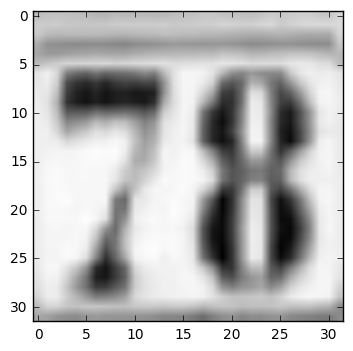

In [4]:
plt.imshow(all_data[0].reshape(32, 32), cmap=plt.cm.Greys)
print(all_labels[0])

In [15]:
def init(random_state):
    train_model = MultiDigits()
    # 先赋值，再定义图
    train_model.train_data, train_model.test_data, train_model.train_labels, train_model.test_labels = \
            train_test_split(all_data, all_labels, test_size=0.2, random_state=random_state)
    
    # 由于GPU的Memory没有那么大，因此这里取部分数据
    train_model.valid_data, train_model.valid_labels = \
        train_model.test_data[9000:18000,...], train_model.test_labels[9000:18000,...]
    
    train_model.test_data, train_model.test_labels = \
        train_model.test_data[0:9000,...], train_model.test_labels[0:9000,...]
    # 定义图
    train_model.define_graph(keep_pro=0.95, eta=0.05, decay_step=5000, decay_rate=0.95)
    print(train_model.train_data.shape, train_model.train_labels.shape)
    print(train_model.test_data.shape, train_model.test_labels.shape)
    print(train_model.valid_data.shape, train_model.valid_labels.shape)
    
    return train_model

In [6]:
# train it
epoch_index_test, losses_test, mini_batch_acc_test, valid_batch_acc_test, test_acc_test = \
        train_model.train_model(save_path='ckpt_data/SVHN.ckpt', save=True, epoch=50000, verbose=True)

Initialized all variables
Minibatch loss at step 0: 20.166700
Minibatch accuracy: 18.8%
Validation accuracy: 52.2%
Minibatch loss at step 1000: 5.066279
Minibatch accuracy: 71.9%
Validation accuracy: 73.1%
Minibatch loss at step 2000: 2.601651
Minibatch accuracy: 87.2%
Validation accuracy: 84.5%
Minibatch loss at step 3000: 2.751622
Minibatch accuracy: 88.0%
Validation accuracy: 87.1%
Minibatch loss at step 4000: 4.001742
Minibatch accuracy: 81.0%
Validation accuracy: 88.5%
Minibatch loss at step 5000: 2.498382
Minibatch accuracy: 87.8%
Validation accuracy: 89.3%
Minibatch loss at step 6000: 2.621090
Minibatch accuracy: 89.3%
Validation accuracy: 89.9%
Minibatch loss at step 7000: 2.119305
Minibatch accuracy: 91.7%
Validation accuracy: 90.2%
Minibatch loss at step 8000: 2.210606
Minibatch accuracy: 90.6%
Validation accuracy: 90.4%
Minibatch loss at step 9000: 1.886064
Minibatch accuracy: 91.9%
Validation accuracy: 90.8%
Minibatch loss at step 10000: 1.836048
Minibatch accuracy: 92.4%
V

In [7]:
del train_model

In [16]:
# 5-fold cross validataion
cv_result = {}

for i in range(5):
    print('>>> cross validation: %s' % i)
    train_model = init(i)
    dir_name = 'cross_%s' % i
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    epoch_index, losses, mini_batch_acc, valid_batch_acc, test_acc = \
        train_model.train_model(save_path='cross_%s/SVHN.ckpt' % i, save=True, epoch=50000, verbose=True)
    cv_result[i] = {'epoch_index': epoch_index, 'losses': losses, 'mini_batch_acc': mini_batch_acc, \
                    'valid_batch_acc': valid_batch_acc, 'test_acc': test_acc}
    del train_model

>>> cross validation: 0
((199057, 32, 32, 1), (199057, 6))
((9000, 32, 32, 1), (9000, 6))
((9000, 32, 32, 1), (9000, 6))
Initialized all variables
Minibatch loss at step 0: 16.258226
Minibatch accuracy: 14.1%
Validation accuracy: 52.9%
Minibatch loss at step 1000: 4.001462
Minibatch accuracy: 78.9%
Validation accuracy: 78.5%
Minibatch loss at step 2000: 2.409515
Minibatch accuracy: 88.8%
Validation accuracy: 87.4%
Minibatch loss at step 3000: 1.909559
Minibatch accuracy: 92.7%
Validation accuracy: 89.7%
Minibatch loss at step 4000: 2.117732
Minibatch accuracy: 90.6%
Validation accuracy: 90.7%
Minibatch loss at step 5000: 1.557809
Minibatch accuracy: 93.0%
Validation accuracy: 91.3%
Minibatch loss at step 6000: 1.665587
Minibatch accuracy: 91.7%
Validation accuracy: 91.6%
Minibatch loss at step 7000: 2.144474
Minibatch accuracy: 91.4%
Validation accuracy: 91.5%
Minibatch loss at step 8000: 1.858371
Minibatch accuracy: 92.7%
Validation accuracy: 92.2%
Minibatch loss at step 9000: 1.66147

In [19]:
for k, v in cv_result.iteritems():
    print(k, v['test_acc'])

(0, 94.07592592592592)
(1, 94.38703703703703)
(2, 94.36296296296297)
(3, 94.4037037037037)
(4, 93.65185185185186)


In [23]:
print('average test accuracy: %s' % (sum([v['test_acc'] for _, v in cv_result.iteritems()]) / len(cv_result.keys())))

average test accuracy: 94.1762962963
